# Normalization

## Introduction
Single cell 데이터는 지저분하고 노이즈를 포함하는 경우가 많습니다. 이것이 데이터를 분석하기 전에 정규화 프로세스를 거치는 이유입니다. 이번에도 역시 이전 노트북에서 구한 QC가 된 데이터로 작업하고 PCA를 사용하여 결과를 시각화할 것입니다. 

In [2]:
import scanpy as sc
adata = sc.read('./data/brain_qc.h5ad')

## PCA

PCA는 principle components analysis의 약자입니다. Dimensionality reduction 방법들은 많은 변수가 든 set를 가지고 오리지널 데이터 세트에 있는 대부분의 정보를 포함하는 더 작은 set를 구하는 것이 목적입니다. 이런 차원 축소 방법 중 하나가 PCA입니다. PCA는 서로 연관이 있는 여러 변수를 PC(principal components)라고 하는 더 적은 수의 상관있지 않은 변수로 변환하는 수학적 방법입니다. PCA를 사용하여 데이터의 전반적인 것을 시각화하고 cofounding 요인을 찾을 수 있습니다.

Normalization을 하기 전 QC를 거친 데이터를 시각화해봅니다.

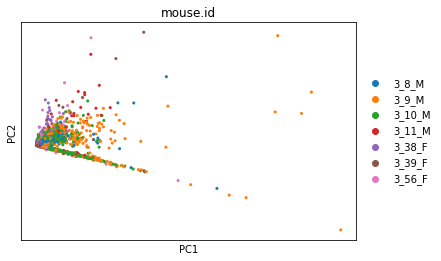

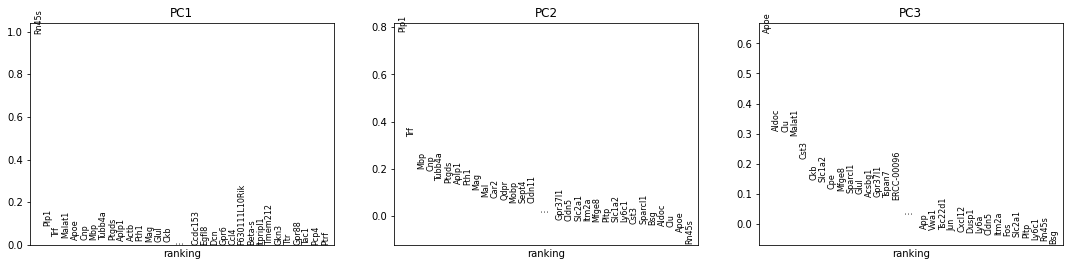

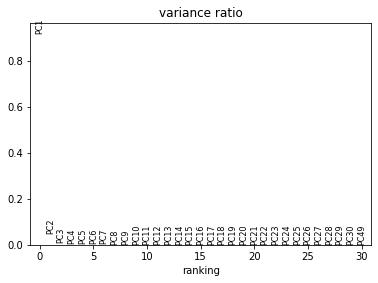

In [3]:
# PCA 좌표, loadings 및 variance decomposition을 계산합니다.
sc.pp.pca(adata)
# PCA 결과를 plotting 합니다
sc.pl.pca_overview(adata, color='mouse.id')

위 플롯들에서 알 수 있는 것
* 첫 번째 플롯에는 선형적인 PC1이 있습니다.
* 두 번째 플롯은 원본 데이터의 각 변수가 각 PC에 얼마나 강하게 기여하는지 나타내는 로딩을 보여줍니다.
* 마지막 플롯은 PC1가 raw 데이터 variation의 대부분을 캡처한다는 것을 보여줍니다.

## Normalize cell library size
라이브러리의 크기는 자연적으로 차이나는 세포의 크기, RNA 캡처의 변형 등을 포함한 여러 가지 이유로 다양합니다.

### CPM
데이터를 정규화하는 가장 간단한 방법은 각 행을 size factor(행의 모든 counts의 합)로 나눈 다음 1,000,000을 곱하여 데이터를 CPM으로 변환하는 것입니다.

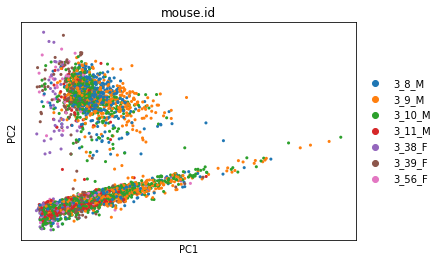

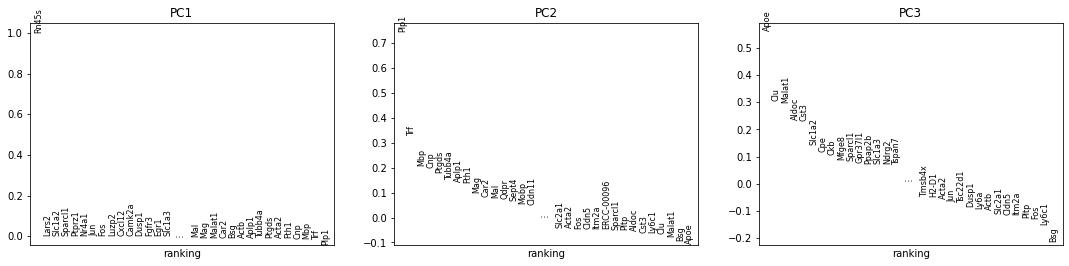

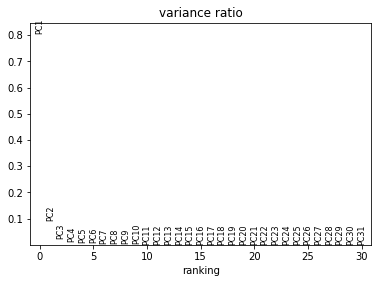

In [4]:
# 추후 비교를 위해 복사본을 만듭니다
adata_cpm = adata.copy()
adata_cpm.raw = adata_cpm
# target_sum을 1e6로 지정하면 CPM 정규화입니다
sc.pp.normalize_total(adata_cpm, target_sum=1e6)
sc.pp.pca(adata_cpm)
sc.pl.pca_overview(adata_cpm, color='mouse.id')

CPM의 단점을 완화하는 한 가지 방법은 size factor estimation에서 많이 발현되는 유전자를 제외하는 것이라고 합니다.

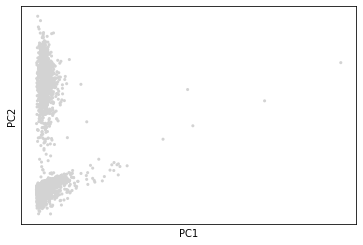

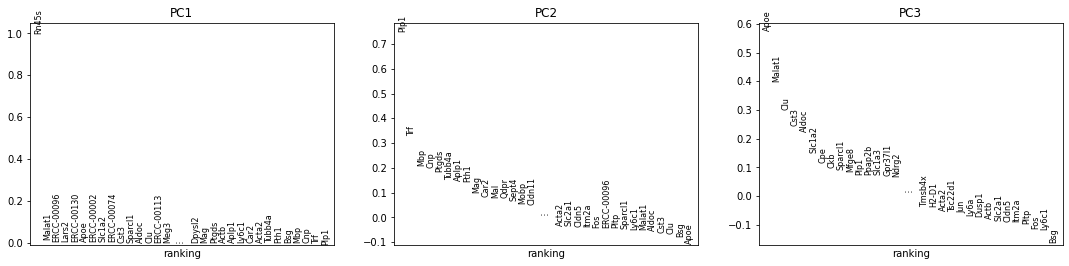

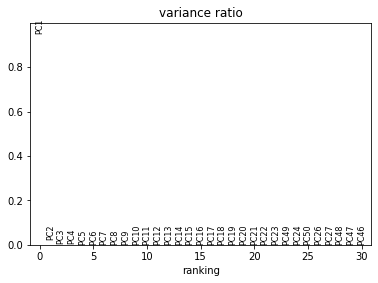

In [5]:
adata_cpm_ex = adata.copy()
# exclude_highly_expressed를 True로 설정합니다
sc.pp.normalize_total(adata_cpm_ex, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.pca(adata_cpm_ex)
sc.pl.pca_overview(adata_cpm_ex)

## Normalize gene expression

### Removing highly expressed genes

이 데이터 세트에는 하나 이상의 많이 발현된 유전자에 의해 지배됩니다. 만약 제거하면 더 합리적인 분석을 할 수 있는지 테스트해 볼 수 있습니다. 위의 2번째 플롯에서 볼 수 있듯이 Rn45s 유전자가 높게 발현이 됩니다. 이를 제거해 보도록 하겠습니다. 

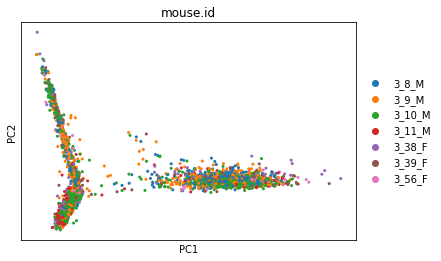

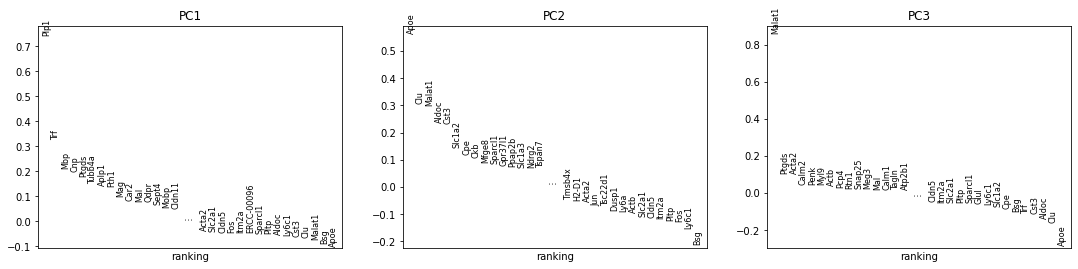

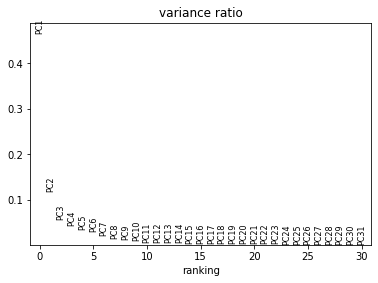

In [6]:
not_Rn45s = adata_cpm.var.index != 'Rn45s'
adata_no_Rn45s = adata_cpm[:, not_Rn45s]
sc.pp.pca(adata_no_Rn45s)
sc.pl.pca_overview(adata_no_Rn45s, color='mouse.id')

마지막 플롯의 결과를 보면, PC1 이외에도 높은 variance ratio를 가지는 PC들이 생겼습니다. 이것은 긍정적인 결과지만 플롯 2를 본다면 아직도 제거해야 할 유전자가 조금 있다는 것을 볼 수 있습니다. 

### De-emphasizing highly expresssed genes
유전자 발현을 표준화하는 방법은 발현 값 데이터를 0을 중심으로 정렬하고 표준 편차를 기준으로 크기 조정하는 것입니다(center and scale). 먼저 각 값에 log(1+x)를 취합니다. +1을 하는 이유는 원래 데이터에서의 0 값이 centering 이후의 로그 공간에서도 0에 매핑 되도록 하기 위해서입니다. 그 후에 각 유전자에 대한 mean 발현 값을 빼고 표준 편차로 나눠줍니다.

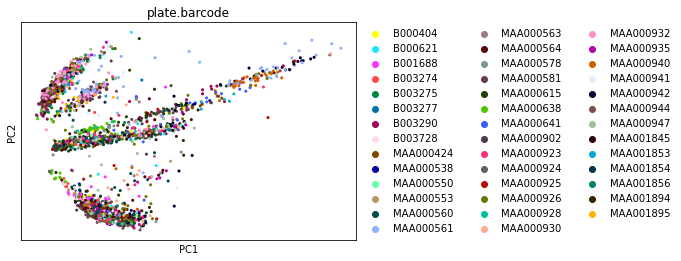

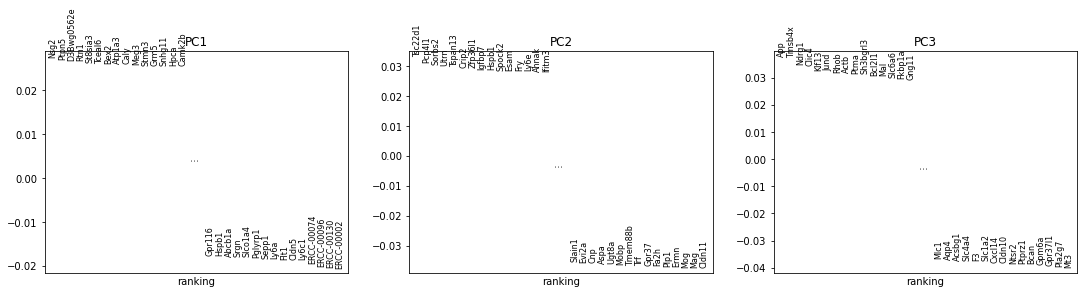

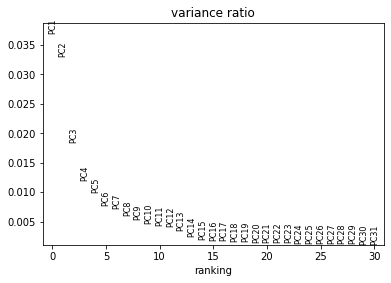

In [7]:
# Step 1: 0을 중심으로 정렬 (center)
sc.pp.log1p(adata_cpm)
# Step 2: 표준 편차를 기준으로 크기 조정 (scale)
sc.pp.scale(adata_cpm)
sc.pp.pca(adata_cpm)
sc.pl.pca_overview(adata_cpm, color='plate.barcode')

마지막 플롯을 보면 처음 ~5-10개의 PC가 데이터의 일부 variance를 캡처한다는 것을 볼 수 있습니다. 

마지막으로 정규화 된 데이터를 파일에 저장합니다. 

In [8]:
adata_cpm.write('./data/brain_normalized.h5ad')

# Compute & Embed neighborhood graph
## Introduction

위에서 dimensionality reduction 중 유명한 PCA에 대한 예시들을 봤습니다. 차원 축소를 진행하게 되면 정보 손실과 향상된 해석 결과로 합니다. 이 둘 사이에서 적당한 밸런스를 찾는 것이 중요합니다. 일부 정보를 버리지만 RNA에 관한 많은 정보를 이해하는데 중요한 역할을 합니다.

위에서 구한 정규화된 마우스 두뇌 데이터로 계속 작업하겠습니다.

In [9]:
adata = sc.read('./data/brain_normalized.h5ad')

## UMAP

Dimensionality reduction에 PCA 말고 tSNE와 UMAP이 있는데, UMAP을 사용하여 2차원으로 그래프를 embedding 하는 것이 tSNE를 사용하는 것보다 낫다고 합니다. UMAP은 일반적으로 유사한 세포를 함께 그룹화하고 세포 유형 간에 분리하는 작업을 잘하는 편입니다.

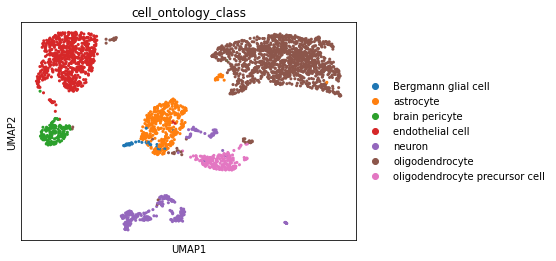

In [10]:
sc.pp.neighbors(adata) # UMAP is based on the neighbor graph; we'll compute this first
sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=1, n_components=2)
sc.pl.umap(adata, color='cell_ontology_class')

In [11]:
adata.write('./data/brain_embeddings.h5ad')